# **Random Forest Stock Trend Classifier (v2)**

### **Key Improvements in this Version:**

**Stationary Features:** Replaced raw prices (which confuse ML models over long periods) with Ratios, Distances, and Oscillators. </br>
**Advanced Indicators:** Added ATR (Volatility), VWAP (Institutional Volume), ADX (Trend Strength), and OBV (Momentum). </br>
**Dynamic Targeting:** Instead of a fixed threshold, the target is now based on volatility (1.0x ATR). This adapts to both calm and volatile markets. </br>
**Walk-Forward Validation:** Uses TimeSeriesSplit to test the model on multiple "future" windows. </br>

### **Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### **Configuration**

In [2]:
# CHANGE TO DESIRED VALUES
TICKER = "NVDA"
START_DATE = "2015-12-01"
END_DATE = "2025-12-05"
PREDICTION_DAYS = 5

### **Data Download/Transform Helper Function**

In [3]:
def get_data(ticker, start=None, end=None, period=None):
    print(f"Downloading data for {ticker}...")
    try:
        if period:
            df = yf.download(ticker, period=period, progress=False, auto_adjust=True)
        else:
            df = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
    except Exception as e:
        print(f"Error: {e}")

    # Fix for recent yfinance versions returning MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
        
    # Drop rows with 0 volume (market closed/errors)
    df = df[df['Volume'] > 0].copy()
    return df

### **Feature Engineering Helper Function**

In [4]:
def add_technical_indicators(df):
    df = df.copy()
    
    # 1. VOLATILITY (ATR)
    prev_close = df['Close'].shift(1)
    tr1 = df['High'] - df['Low']
    tr2 = (df['High'] - prev_close).abs()
    tr3 = (df['Low'] - prev_close).abs()
    df['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['ATR'] = df['TR'].rolling(window=14).mean()
    df['ATR_Perc'] = df['ATR'] / df['Close']

    # 2. TREND STRENGTH (ADX)
    plus_dm = df['High'].diff()
    minus_dm = df['Low'].diff()
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), -minus_dm, 0.0)
    
    plus_di = 100 * (pd.Series(plus_dm, index=df.index).ewm(alpha=1/14).mean() / df['ATR'])
    minus_di = 100 * (pd.Series(minus_dm, index=df.index).ewm(alpha=1/14).mean() / df['ATR'])
    
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    df['ADX'] = dx.ewm(alpha=1/14).mean()

    # 3. VOLUME & MOMENTUM
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    df['OBV_Slope'] = df['OBV'].diff(5)
    
    v_price = df['Close'] * df['Volume']
    df['VWAP_20'] = v_price.rolling(window=20).sum() / df['Volume'].rolling(window=20).sum()
    df['Dist_VWAP'] = (df['Close'] - df['VWAP_20']) / df['VWAP_20']

    # 4. SUPPORT / RESISTANCE
    df['High_20'] = df['High'].rolling(window=20).max()
    df['Low_20'] = df['Low'].rolling(window=20).min()
    df['Dist_High_20'] = (df['High_20'] - df['Close']) / df['Close']
    df['Dist_Low_20'] = (df['Close'] - df['Low_20']) / df['Close']

    # 5. OSCILLATORS
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).ewm(span=14, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(span=14, adjust=False).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['Dist_SMA_50'] = (df['Close'] - df['SMA_50']) / df['SMA_50']
    
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Norm_MACD'] = df['MACD'] / df['Close']

    # 6. CANDLESTICK STATS
    df['Body_Size'] = (df['Close'] - df['Open']).abs()
    df['Total_Range'] = df['High'] - df['Low']
    df['Body_Perc'] = df['Body_Size'] / df['Total_Range']

    return df

### **Execution: Load and Process Data**

In [5]:
df = get_data(TICKER, START_DATE, END_DATE)
print(f"Raw Data Shape: {df.shape}")

df = add_technical_indicators(df)

# Drop NaNs generated by rolling windows (e.g., SMA_50 needs 50 days of data)
df.dropna(inplace=True)
print(f"Data Shape after Feature Engineering: {df.shape}")

Raw Data Shape: (2518, 5)
Data Shape after Feature Engineering: (2469, 25)


### **Target Creation**

In [6]:
# Calculate Future Return
df['Future_Close'] = df['Close'].shift(-PREDICTION_DAYS)
df['Actual_Return'] = df['Future_Close'] - df['Close']

def label_data_dynamic(row):
    # Dynamic Threshold: We only trade if the move is larger than recent volatility (ATR)
    volatility_barrier = row['ATR'] * 1.0
    
    if row['Actual_Return'] > volatility_barrier:
        return 1  # Buy
    elif row['Actual_Return'] < -volatility_barrier:
        return -1 # Sell
    else:
        return 0  # Hold

df['Target'] = df.apply(label_data_dynamic, axis=1)

# Drop last rows where future data is NaN
df.dropna(inplace=True)

print("Class Distribution:\n", df['Target'].value_counts())

Class Distribution:
 Target
 0    1124
 1     853
-1     487
Name: count, dtype: int64


### **Model Training**

In [7]:
# Select only Stationary/Normalized features for the model
features = [
    'RSI', 'ADX', 'ATR_Perc',        # Momentum & Volatility
    'Dist_VWAP', 'Dist_SMA_50',      # Trend Deviations
    'Norm_MACD', 'OBV_Slope',        # Oscillators
    'Dist_High_20', 'Dist_Low_20',   # Support/Resistance
    'Body_Perc'                      # Price Action
]

X = df[features]
y = df['Target']

# TimeSeriesSplit prevents data leakage by ensuring we only train on past data
tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestClassifier(n_estimators=200, min_samples_split=10, 
                               max_depth=10, class_weight='balanced', 
                               random_state=42)

print("Performing Walk-Forward Validation...")
scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    scores.append(acc)
    print(f"Fold Accuracy: {acc:.4f}")

print(f"\nAverage Walk-Forward Accuracy: {np.mean(scores):.4f}")

# Final Training on the most recent split (85% Train, 15% Test)
split = int(len(X) * 0.85)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

model.fit(X_train, y_train)
print("Final Model Trained.")

Performing Walk-Forward Validation...
Fold Accuracy: 0.3293
Fold Accuracy: 0.4366
Fold Accuracy: 0.3976
Fold Accuracy: 0.4171
Fold Accuracy: 0.3756

Average Walk-Forward Accuracy: 0.3912
Final Model Trained.


### **Model Evaluation and Visualization**


Classification Report (Test Data):
              precision    recall  f1-score   support

          -1       0.22      0.22      0.22        82
           0       0.51      0.36      0.42       172
           1       0.30      0.42      0.35       116

    accuracy                           0.35       370
   macro avg       0.34      0.33      0.33       370
weighted avg       0.38      0.35      0.35       370

Saved feature_importance.png


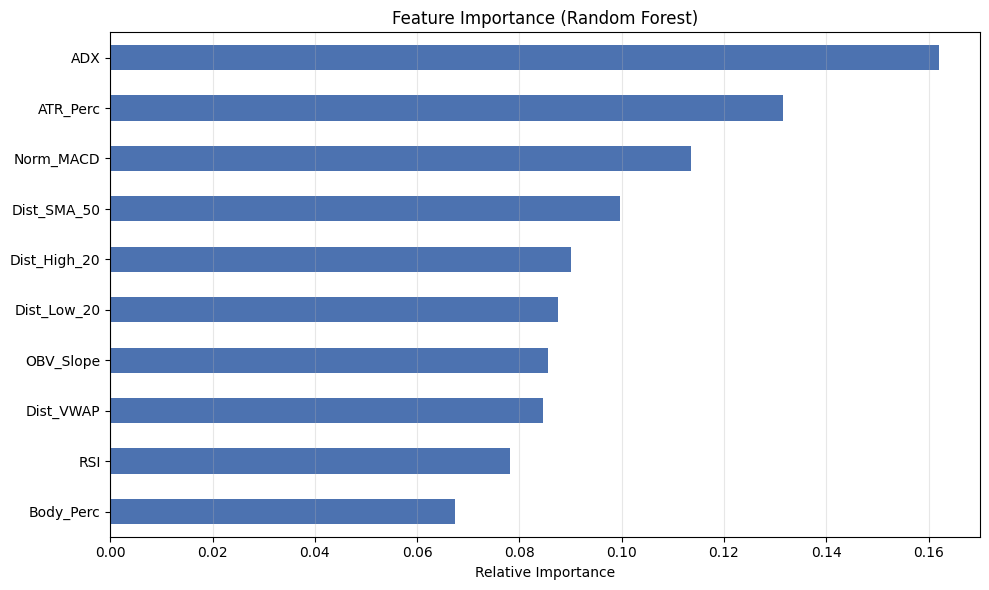

Saved confusion_matrix.png


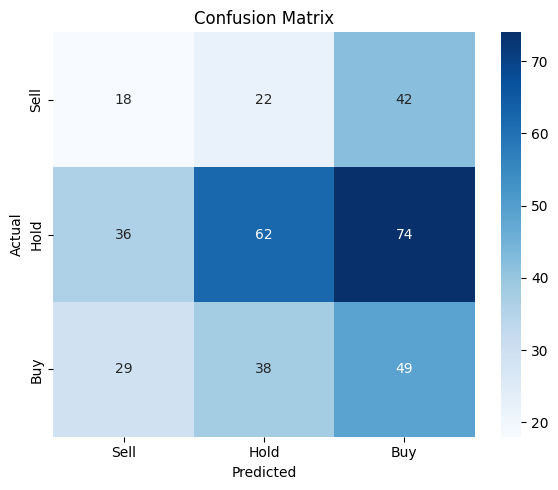

In [8]:
y_pred = model.predict(X_test)

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred))

# 1. Feature Importance Plot
plt.figure(figsize=(10, 6))
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', color='#4c72b0')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Relative Importance")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('images/feature_importance.png', dpi=300) # Save image
print("Saved feature_importance.png")
plt.show()

# 2. Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sell', 'Hold', 'Buy'], yticklabels=['Sell', 'Hold', 'Buy'])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('images/confusion_matrix.png', dpi=300) # Save image
print("Saved confusion_matrix.png")
plt.show()

### **Live Predictor Function**

In [11]:
def predict_live(ticker, model):
    print(f"\n--- Live Analysis for {ticker} ---")
    
    # Download 6 months to ensure rolling windows (like SMA50) are full
    data = get_data(ticker, period="6mo")
    
    # Apply EXACT same feature engineering
    data = add_technical_indicators(data)
    
    # Grab the specific feature columns for the latest day
    latest_features = data.iloc[[-1]][features]
    
    # Predict
    prediction = model.predict(latest_features)[0]
    probs = model.predict_proba(latest_features)[0]
    
    # Mapping
    label_map = {1: "BUY", -1: "SELL", 0: "HOLD"}
    
    # Context Stats
    current_price = data.iloc[-1]['Close']
    current_atr = data.iloc[-1]['ATR']
    current_adx = data.iloc[-1]['ADX']
    current_rsi = data.iloc[-1]['RSI']
    
    print(f"Current Price: ${current_price:.2f}")
    print(f"Current Volatility (ATR): {current_atr:.2f}")
    print(f"Trend Strength (ADX): {current_adx:.2f} (>25 is trending)")
    print(f"Momentum (RSI): {current_rsi:.2f}")
    print(f"\nModel Prediction: {label_map[prediction]}")
    print(f"Confidence: Sell {probs[0]:.2f} | Hold {probs[1]:.2f} | Buy {probs[2]:.2f}")

In [12]:
# Run Live Prediction
predict_live(TICKER, model)


--- Live Analysis for NVDA ---
Current Price: $182.41
Current Volatility (ATR): 7.17
Trend Strength (ADX): -256.11 (>25 is trending)
Momentum (RSI): 49.43

Model Prediction: BUY
Confidence: Sell 0.15 | Hold 0.34 | Buy 0.50
